Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
from random import randint, choice
from sklearn import metrics, preprocessing, model_selection
import math
import matplotlib.pyplot as plt

Carregando os dados

In [2]:
colunas = ['variance_wavelet_transformed_image', 'skewness_wavelet_transformed_image', 'curtosis_wavelet_transformed_image', 'entropy_image', 'class']
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', names=colunas)
dataset.reset_index(level=0, inplace=True)
dataset.head()

,index,variance_wavelet_transformed_image,skewness_wavelet_transformed_image,curtosis_wavelet_transformed_image,entropy_image,class
0,0,3.62160,8.6661,-2.8073,-0.44699,0
1,1,4.54590,8.1674,-2.4586,-1.46210,0
2,2,3.86600,-2.6383,1.9242,0.10645,0
3,3,3.45660,9.5228,-4.0112,-3.59440,0
4,4,0.32924,-4.4552,4.5718,-0.98880,0


Normalizando os dados

In [3]:
def normalizar(dataset):
  dataset_norm = {}
  for i in range(0, len(dataset.columns)):
    if ((dataset.columns[i] != 'index') and (dataset.columns[i] != 'class')):
      coluna = dataset.columns[i]
      valores = []
      for j in range(0, len(dataset[coluna])):
        a = ((dataset[coluna][j]-min(dataset[coluna]))/ (max(dataset[coluna])-min(dataset[coluna])))
        valores.append(a)
      dataset_norm[coluna] = valores

  return dataset_norm

In [4]:
dataset_norm = normalizar(dataset)
dataset_norm = pd.DataFrame(dataset_norm, columns=list(dataset_norm.keys()))
dataset_norm.reset_index(level=0, inplace=True)
dataset_norm.head()

,index,variance_wavelet_transformed_image,skewness_wavelet_transformed_image,curtosis_wavelet_transformed_image,entropy_image
0,0,0.769004,0.839643,0.106783,0.736628
1,1,0.835659,0.820982,0.121804,0.644326
2,2,0.786629,0.416648,0.310608,0.786951
3,3,0.757105,0.871699,0.054921,0.450440
4,4,0.531578,0.348662,0.424662,0.687362


In [5]:
def padronizar(dataset):
  transformer = preprocessing.StandardScaler().fit(dataset)
  dataset_norm = transformer.transform(dataset)
  
  return pd.DataFrame(dataset_norm, columns=dataset.columns).drop(['index', 'class'],axis=1)

In [6]:
dataset_padr = padronizar(dataset)
dataset_padr.reset_index(level=0, inplace=True)
dataset_padr.head()

,index,variance_wavelet_transformed_image,skewness_wavelet_transformed_image,curtosis_wavelet_transformed_image,entropy_image
0,0,1.121806,1.149455,-0.975970,0.354561
1,1,1.447066,1.064453,-0.895036,-0.128767
2,2,1.207810,-0.777352,0.122218,0.618073
3,3,1.063742,1.295478,-1.255397,-1.144029
4,4,-0.036772,-1.087038,0.736730,0.096587


In [7]:
def calcularSigma2(dataset_norm_padr):
  sigmas = [0] * len(dataset_norm_padr.columns[1:])
  distancias = {}
  colunas = list(dataset_norm.columns[1:])

  for c in range(0, len(dataset_norm_padr.columns[1:])):
    distancias[colunas[c]] = []
    for i in range(0, len(dataset_norm_padr)):
      dists = []
      for j in range(0, len(dataset_norm_padr)):
        if i != j:
          dists.append((np.linalg.norm(dataset_norm_padr[dataset_norm_padr.columns[c+1]][i]-dataset_norm_padr[dataset_norm_padr.columns[c+1]][j])**2))
      distancias[colunas[c]] += dists
    distancias[colunas[c]].sort()
    sigmas[c] = (np.percentile(distancias[colunas[c]], 10) + np.percentile(distancias[colunas[c]], 90))/2

  return sigmas

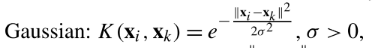

In [8]:
def kernelGaussiano(a, b, sigma):
  return np.exp(1)**(-((np.linalg.norm(a-b)**2)/sigma))

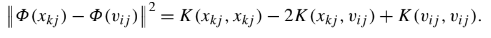

In [9]:
def distanciaKernelGaussiano(a, b, sigma):
  return (kernelGaussiano(a, a, sigma) - (2*(kernelGaussiano(a, b, sigma))) + kernelGaussiano(b, b, sigma))

Gerando grupos iniciais

In [13]:
def inicializar(k, dados):
  matrizU = {}
  prototipos = {}

  for i in range(0, len(dados)):
    graus = [0] * k
    soma = 0
    for j in range(0, k):
      a = randint(1, 10)
      graus[j] = a
    matrizU[i] = graus

  for i in range(0, len(matrizU)):
    soma = sum(matrizU[i])
    for j in range(0, len(matrizU[i])):
      matrizU[i][j] = (matrizU[i][j]/soma)

  for g in range(0, k):
    n = 0
    prototipo = [0] * len(dados.columns[1:])
    n = choice(range(len(dados)))
    for c in range(0, len(dados.columns[1:])):
      prototipo[c] = dados[dados.columns[c+1]][n]
    prototipos[g] = prototipo

  return matrizU, prototipos

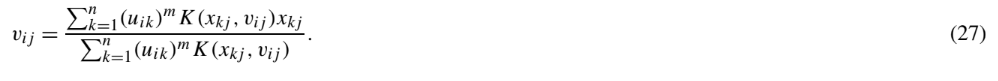

In [14]:
def gerarPrototipos(dados, matrizU, prototipos, sigmas, k, m):
  novosPrototipos = {}

  for g in range(0, k):
    features = [0] * len(dados.columns[1:])
    geral = [0] * len(dados.columns[1:])
    for l in range(0, len(dados)):
      for c in range(0, len(dados.columns[1:])):
        features[c] = features[c] + (((matrizU[l][g]**m))*(kernelGaussiano(dados[dados.columns[c+1]][l], prototipos[g][c], sigmas[c]))*(dados[dados.columns[c+1]][l]))
        geral[c] = geral[c] + ((matrizU[l][g]**m)*(kernelGaussiano(dados[dados.columns[c+1]][l], prototipos[g][c], sigmas[c])))
    for a in range(0, len(features)):
      features[a] = features[a]/geral[a]

    novosPrototipos[g] = features

  return novosPrototipos

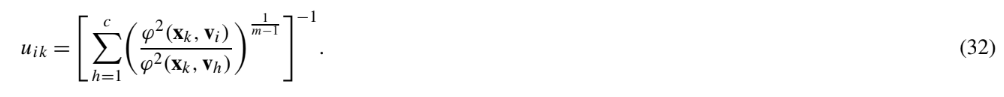

In [15]:
def gerarMatrizU(dataset_norm, prototipos, pesos, sigmas, k, m):
  matrizU = {}
  
  for l in range(0, len(dataset_norm)):
    distancias = [0] * k
    for h in range(0, k):
      for c in range(0, len(dataset_norm.columns[1:])):
        distancias[h] = distancias[h] + (pesos[h][c]*(distanciaKernelGaussiano(dataset_norm[dataset_norm.columns[c+1]][l], prototipos[h][c], sigmas[c])))
    matrizU[l] = distancias

  for l in range(0, len(dataset_norm)):
    soma = sum(matrizU[l])
    for g in range(0, k):
      matrizU[l][g] = (((matrizU[l][g]/soma)**(1/(m-1)))**(-1))
      
  for l in range(0, len(dataset_norm)):
    soma = sum(matrizU[l])
    for g in range(0, k):
      matrizU[l][g] = matrizU[l][g]/soma

  return matrizU

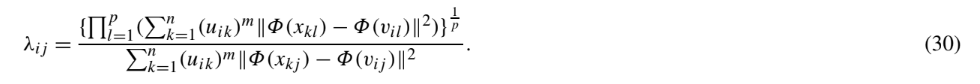

In [16]:
def calcularPesos(dataset_norm, matrizU, prototipos, sigmas, k, m):
  gruposFeatures = {}
  pesos = {}

  for g in range(0, k):
    features = [0] * len(dataset_norm.columns[1:])
    for l in range(0, len(dataset_norm)):
      for c in range(0, len(dataset_norm.columns[1:])):
        features[c] = features[c] + ((matrizU[l][g]**m)*distanciaKernelGaussiano(dataset_norm[dataset_norm.columns[c+1]][l], prototipos[g][c], sigmas[c]))
    gruposFeatures[g] = features

  for g in range(0, k):
    produto = np.prod(gruposFeatures[g])
    features = [0] * len(dataset_norm.columns[1:])
    for c in range(0, len(dataset_norm.columns[1:])):
      features[c] = ((produto)**(1/len(dataset_norm.columns[1:])))/gruposFeatures[g][c]
    pesos[g] = features

  return pesos

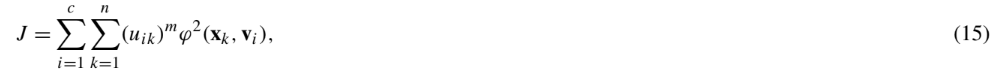

In [17]:
def criterioJ(dataset_norm, matrizU, prototipos, pesos, sigmas, k, m):
  j = 0
  for g in range(0, k):
    for l in range(0, len(dataset_norm)):
      distancias = 0
      for c in range(0, len(dataset_norm.columns[1:])):
        distancias = distancias + ((pesos[g][c])*(distanciaKernelGaussiano(dataset_norm[dataset_norm.columns[c+1]][l], prototipos[g][c], sigmas[c])))
      j = j + ((matrizU[l][g])**m)*distancias

  return j

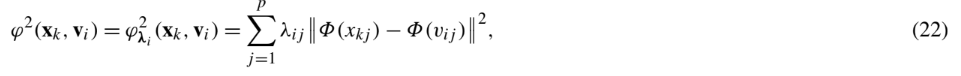

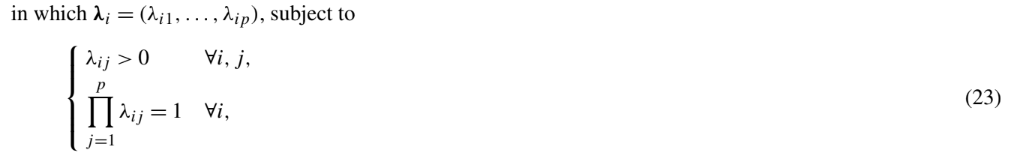

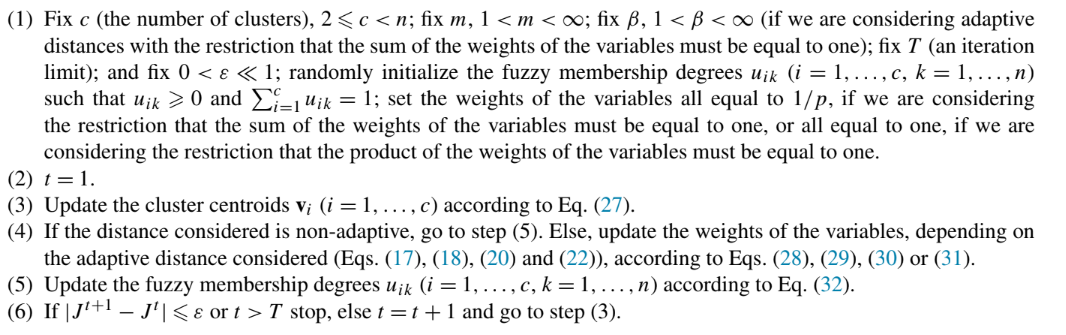

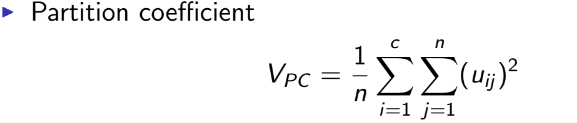

In [18]:
def calcPC(matrizU, k):
  vpc = 0

  for c in range(0, k):
    for n in range(0, len(matrizU)):
      vpc += (matrizU[n][c])**2

  vpc = vpc/len(matrizU)

  return vpc

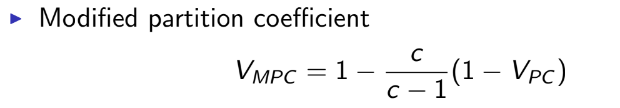

In [19]:
def calcMPC(vpc, k):
  vmpc = 1-(k/(k-1))*(1-vpc)
  return vmpc

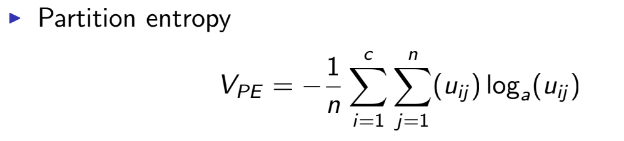

In [20]:
def calcPartitionEntropy(matrizU, k):
  vpe = 0

  for c in range(0, k):
    for n in range(0, len(matrizU)):
      vpe += (matrizU[n][c]*(math.log(matrizU[n][c])))

  vpe = (vpe/len(matrizU))*(-1)

  return vpe

In [21]:
def gerarParticaoCrisp(matrizU, k):
  matrizCrisp = {}
  um = 0
  zero = 0

  for i in range(0, len(matrizU)):
    grupos = [0] * k
    grupo = matrizU[i].index(max(matrizU[i]))
    if grupo == 0:
      zero += 1
    else:
      um += 1
    grupos[grupo] = 1
    matrizCrisp[i] = grupos

  return matrizCrisp, zero, um

In [22]:
def grupos(matrizU):
  grupos = [0] * len(matrizU)

  for i in range(0, len(matrizU)):
    grupos[i] = matrizU[i].index(max(matrizU[i]))

  return grupos

In [23]:
def fit(dataset, matrizUIni, prototiposIni, sigmas, k, m):

  t = 1
  prots = {}
  criterio_j = []
  criterio_j.append(0)

  sigmas = calcularSigma2(dataset)

  matrizU = matrizUIni
  prots[0] = prototiposIni

  while (t<=150):
    prototipos = gerarPrototipos(dataset, matrizU, prots[t-1], sigmas, k, m)
    prots[t] = prototipos
    pesos = calcularPesos(dataset, matrizU, prototipos, sigmas, k, m)
    matrizU = gerarMatrizU(dataset, prototipos, pesos, sigmas, k, m)
    criterio_j.append(criterioJ(dataset, matrizU, prototipos, pesos, sigmas, k, m))

    if abs(criterio_j[t]-criterio_j[t-1]) < e:
      break

    t += 1

  return prototipos, pesos, sigmas, criterio_j

In [24]:
def predict(dataset, prototipos, pesos, sigmas, k, m):
  matrizU = gerarMatrizU(dataset, prototipos, pesos, sigmas, k, m)
  predicoes = grupos(matrizU)

  return predicoes, matrizU

In [25]:
def metricas(classes, predicoes, matrizU, k, prototipos):

  vpc = calcPC(matrizU, k)
  mpc = calcMPC(vpc, k)
  pe = calcPartitionEntropy(matrizU, k)
  crisp, zero, um = gerarParticaoCrisp(matrizU, k)
  rand = metrics.adjusted_rand_score(classes, predicoes)
  f = 2*((metrics.precision_score(classes, predicoes)*metrics.recall_score(classes, predicoes))/(metrics.precision_score(classes, predicoes)+metrics.recall_score(classes, predicoes)))
  ac = metrics.accuracy_score(classes, predicoes)

  return {'PROTOTIPOS': prototipos, 'CRISP': crisp, 'N_ELEMENTOS': list((zero, um)), 'MPC': mpc, 'PE': pe, 'RAND': rand, 'F': f, 'ERRO': (1-ac), 'VPC': vpc}

EXECUÇÃO TREINO/TESTE

[0.11631197330802011, 0.13339172879629743, 0.09654033221259582, 0.10866243519211934]
[0.11255137490579654, 0.13284632498097504, 0.0970745588138575, 0.10382299804817832]
[0.11360787640133281, 0.13823884531928302, 0.09924696533999998, 0.10365759943087569]
[0.11332997849050078, 0.13535634671023938, 0.098793336334237, 0.10469575789321893]
[0.11611139405872117, 0.13353210792504502, 0.09783312690559778, 0.10376921206604472]
[0.11087141575236893, 0.13407363022323165, 0.09519699438906147, 0.10657681141487159]
[0.11630106030686087, 0.13321205666168098, 0.09391733889618094, 0.10811367141572162]
[0.11392238970576093, 0.1337826315843919, 0.09764245767533865, 0.10726899214710471]
[0.11450254303825816, 0.13091866774670577, 0.09414806984906511, 0.10307753508467046]
[0.11452725364530816, 0.135384161234611, 0.09864763003681327, 0.10943140747899414]
0.9733209355079266 0.9466418710158533 0.0445811416465841 0.06326810718775436 0.6433566433566433 0.37090909090909085
0.9833712671489471 0.9667425342978941 0.

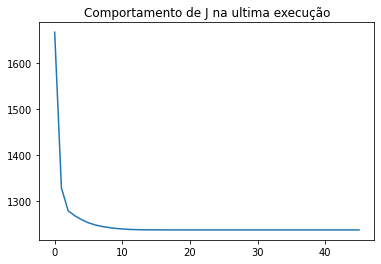

In [ ]:
%%time
sigmas = [0.1144590483705383, 0.1348234224044317, 0.09806471533322812, 0.10603945125069907]
k = 2 #Número de clusters
m = [1.01, 1.1, 1.6, 2.0] #Coeficiente fuzzificador
t = 1 #Iterações
e = 10**(-10) #Critério de parada
execs = 10
taxas = {}

for exec in range(0, execs):  

  treino, teste = model_selection.train_test_split(dataset_norm[dataset_norm.columns[1:]], train_size=0.8)
  treino = pd.DataFrame.reset_index(treino)
  teste = pd.DataFrame.reset_index(teste)

  matrizUIni, prototiposIni = inicializar(2, treino)
  prototipos, pesos, sigmas, criterio_j = fit(treino, matrizUIni, prototiposIni, sigmas, k, m[1])

  predicoes, matrizU = predict(teste, prototipos, pesos, sigmas, k, m[1])

  ids = list(teste['index'])
  classes = list(dataset['class'])

  classes_teste = []
  for a in ids:
    classes_teste.append(classes[a])

  taxas[exec] = metricas(classes_teste, predicoes, matrizU, k, prototipos)

vpcm, mpcm, pem, randm, fm, errom = [],[],[],[],[],[]
for tx in range(0, len(taxas)):
  print(taxas[tx])
  print(taxas[tx]['VPC'], taxas[tx]['MPC'], taxas[tx]['PE'], taxas[tx]['RAND'], taxas[tx]['F'], taxas[tx]['ERRO'])
  vpcm.append(taxas[tx]['VPC'])
  mpcm.append(taxas[tx]['MPC'])
  pem.append(taxas[tx]['PE'])
  randm.append(taxas[tx]['RAND'])
  fm.append(taxas[tx]['F'])
  errom.append(taxas[tx]['ERRO'])

print('MEDIAS = ', list((np.mean(vpcm),np.mean(mpcm), np.mean(pem), np.mean(randm), np.mean(fm), np.mean(errom))))
print('DP = ', list((np.std(vpcm),np.std(mpcm), np.std(pem), np.std(randm), np.std(fm), np.std(errom))))

plt.plot(criterio_j[1:])
plt.title('Comportamento de J na ultima execução')

EXECUÇÃO PARA TODO O DATASET

{'PROTOTIPOS': {0: [0.5828049811975055, 0.7767140853843155, 0.15755879047700902, 0.5476109246701454], 1: [0.5149584635909062, 0.45005014002706367, 0.3588538352246802, 0.7892535398752695]}, 'CRISP': {0: [1, 0], 1: [1, 0], 2: [0, 1], 3: [1, 0], 4: [0, 1], 5: [1, 0], 6: [0, 1], 7: [0, 1], 8: [1, 0], 9: [1, 0], 10: [1, 0], 11: [0, 1], 12: [1, 0], 13: [1, 0], 14: [1, 0], 15: [0, 1], 16: [0, 1], 17: [0, 1], 18: [0, 1], 19: [1, 0], 20: [1, 0], 21: [0, 1], 22: [1, 0], 23: [1, 0], 24: [1, 0], 25: [0, 1], 26: [0, 1], 27: [1, 0], 28: [1, 0], 29: [0, 1], 30: [0, 1], 31: [0, 1], 32: [1, 0], 33: [1, 0], 34: [0, 1], 35: [1, 0], 36: [1, 0], 37: [0, 1], 38: [1, 0], 39: [1, 0], 40: [1, 0], 41: [1, 0], 42: [1, 0], 43: [0, 1], 44: [1, 0], 45: [1, 0], 46: [1, 0], 47: [1, 0], 48: [1, 0], 49: [0, 1], 50: [0, 1], 51: [1, 0], 52: [1, 0], 53: [1, 0], 54: [1, 0], 55: [0, 1], 56: [1, 0], 57: [1, 0], 58: [0, 1], 59: [1, 0], 60: [0, 1], 61: [0, 1], 62: [1, 0], 63: [0, 1], 64: [1, 0], 65: [0, 1], 66: [0, 1], 67: [1,

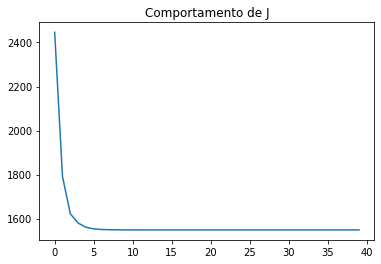

In [26]:
%%time
sigmas = [0.1144590483705383, 0.1348234224044317, 0.09806471533322812, 0.10603945125069907]
k = 2 #Número de clusters
m = [1.01, 1.1, 1.6, 2.0] #Coeficiente fuzzificador
t = 1 #Iterações
e = 10**(-10) #Critério de parada
execs = 1
taxas = {}

for exec in range(0, execs): 

  matrizUIni, prototiposIni = inicializar(2, dataset_norm)
  prototipos, pesos, sigmas, criterio_j = fit(dataset_norm, matrizUIni, prototiposIni, sigmas, k, m[1])

  predicoes, matrizU = predict(dataset_norm, prototipos, pesos, sigmas, k, m[1])

  ids = list(dataset_norm['index'])
  classes = list(dataset['class'])

  classes_teste = []
  for a in ids:
    classes_teste.append(classes[a])

  taxas[exec] = metricas(classes_teste, predicoes, matrizU, k, prototipos)

vpcm, mpcm, pem, randm, fm, errom = [],[],[],[],[],[]
for tx in range(0, len(taxas)):
  print(taxas[tx])
  print(taxas[tx]['VPC'], taxas[tx]['MPC'], taxas[tx]['PE'], taxas[tx]['RAND'], taxas[tx]['F'], taxas[tx]['ERRO'])
  vpcm.append(taxas[tx]['VPC'])
  mpcm.append(taxas[tx]['MPC'])
  pem.append(taxas[tx]['PE'])
  randm.append(taxas[tx]['RAND'])
  fm.append(taxas[tx]['F'])
  errom.append(taxas[tx]['ERRO'])

print('MEDIAS = ', list((np.mean(vpcm),np.mean(mpcm), np.mean(pem), np.mean(randm), np.mean(fm), np.mean(errom))))
print('DP = ', list((np.std(vpcm),np.std(mpcm), np.std(pem), np.std(randm), np.std(fm), np.std(errom))))

plt.plot(criterio_j[1:])
plt.title('Comportamento de J')

Text(0.5, 0, 'Padrão')

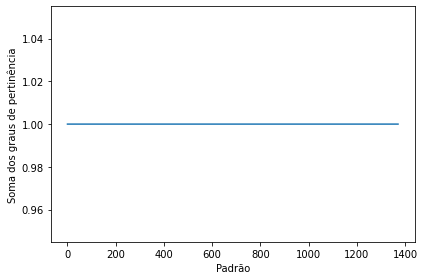

In [27]:
gp = []
g0 = []
g1 = []
for q in range(0, len(matrizU)):
  g0.append(matrizU[q][0])
  g0.append(matrizU[q][1])
  gp.append(sum(matrizU[q]))

fig = plt.figure(tight_layout=True)

ax = fig.add_subplot()
ax.plot(gp)
ax.set_ylabel('Soma dos graus de pertinência')
ax.set_xlabel('Padrão')

In [28]:
gmu = pd.DataFrame(matrizUIni)
gmu = gmu.T

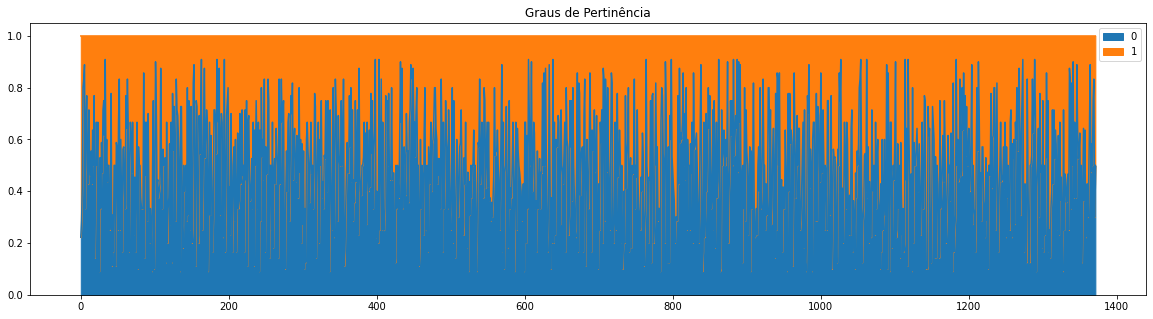

In [29]:
gmu.plot(figsize=(20,5), title='Graus de Pertinência', kind='area')

In [30]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', names=colunas)

In [31]:
#Predições
pred = df.copy()
pred['class'] = grupos(matrizU)
pred1 = pred[pred['class'] == 1]
pred0 = pred[pred['class'] == 0]
pred['class'].value_counts()

1    754
0    618
Name: class, dtype: int64

In [32]:
#Classes Reais
df1 = df.loc[df['class'] == 1]
df0 = df.loc[df['class'] == 0]
df['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [33]:
a0 = (dataset['variance_wavelet_transformed_image'].max() - dataset['variance_wavelet_transformed_image'].min())
a1 = (dataset['skewness_wavelet_transformed_image'].max() - dataset['skewness_wavelet_transformed_image'].min())
m1 = dataset['variance_wavelet_transformed_image'].min()
m2 = dataset['skewness_wavelet_transformed_image'].min()

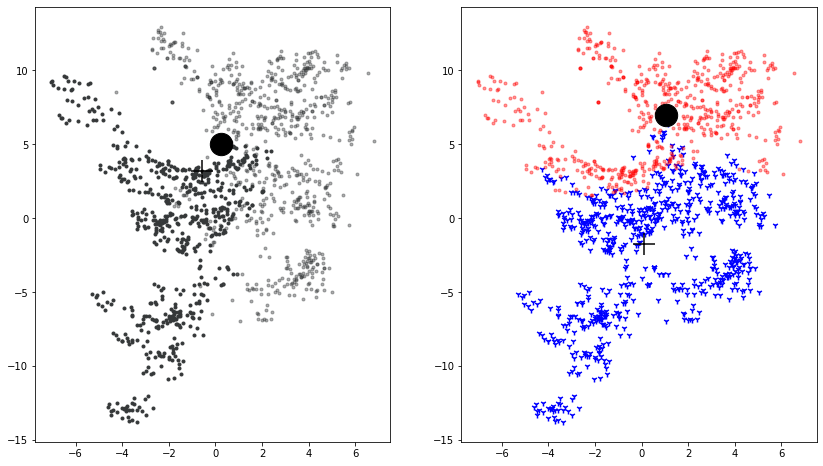

In [34]:
plt.figure(figsize=(14,8))
ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.scatter(df1[df.columns[0]],df1[df.columns[1]],c='#353839',marker='.')
ax1.scatter(df0[df.columns[0]],df0[df.columns[1]],c='#353839',marker='.',alpha=0.4)
ax2.scatter(pred1[df.columns[0]],pred1[df.columns[1]],c='#0000ff',marker='1')
ax2.scatter(pred0[df.columns[0]],pred0[df.columns[1]],c='#ff0000',marker='.',alpha=0.4)
ax1.scatter((prototiposIni[1][0]*a0)+m1,(prototiposIni[1][1]*a1)+m2,c='#000000',marker='+', s=500)
ax1.scatter((prototiposIni[0][0]*a0)+m1,(prototiposIni[0][1]*a1)+m2,c='#000000',marker='o', s=500)
ax2.scatter((prototipos[1][0]*a0)+m1,(prototipos[1][1]*a1)+m2,c='#000000',marker='+', s=500)
ax2.scatter((prototipos[0][0]*a0)+m1,(prototipos[0][1]*a1)+m2,c='#000000',marker='o', s=500)